# Accessing LATISS Data with the Butler

In [1]:
import os
import numpy as np
import glob
from astropy.io import fits
import pickle as pkl
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table, vstack, join
from scipy import stats
from scipy.optimize import curve_fit
from lsst.obs.lsst import Latiss
camera = Latiss().getCamera()
from matplotlib.pyplot import cm
from scipy import stats
from scipy import interpolate
import matplotlib.ticker as mticker

def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('linear', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')


##### First we are going to setup a butler to repository where the LATISS data is ingested on USDF.<br>Here wea re just going to pull some raw images from a specific date and time.

##### You can look up on Rubin TV to check which date, or copy the dataID for a specific exposure.<br>
https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-05-23

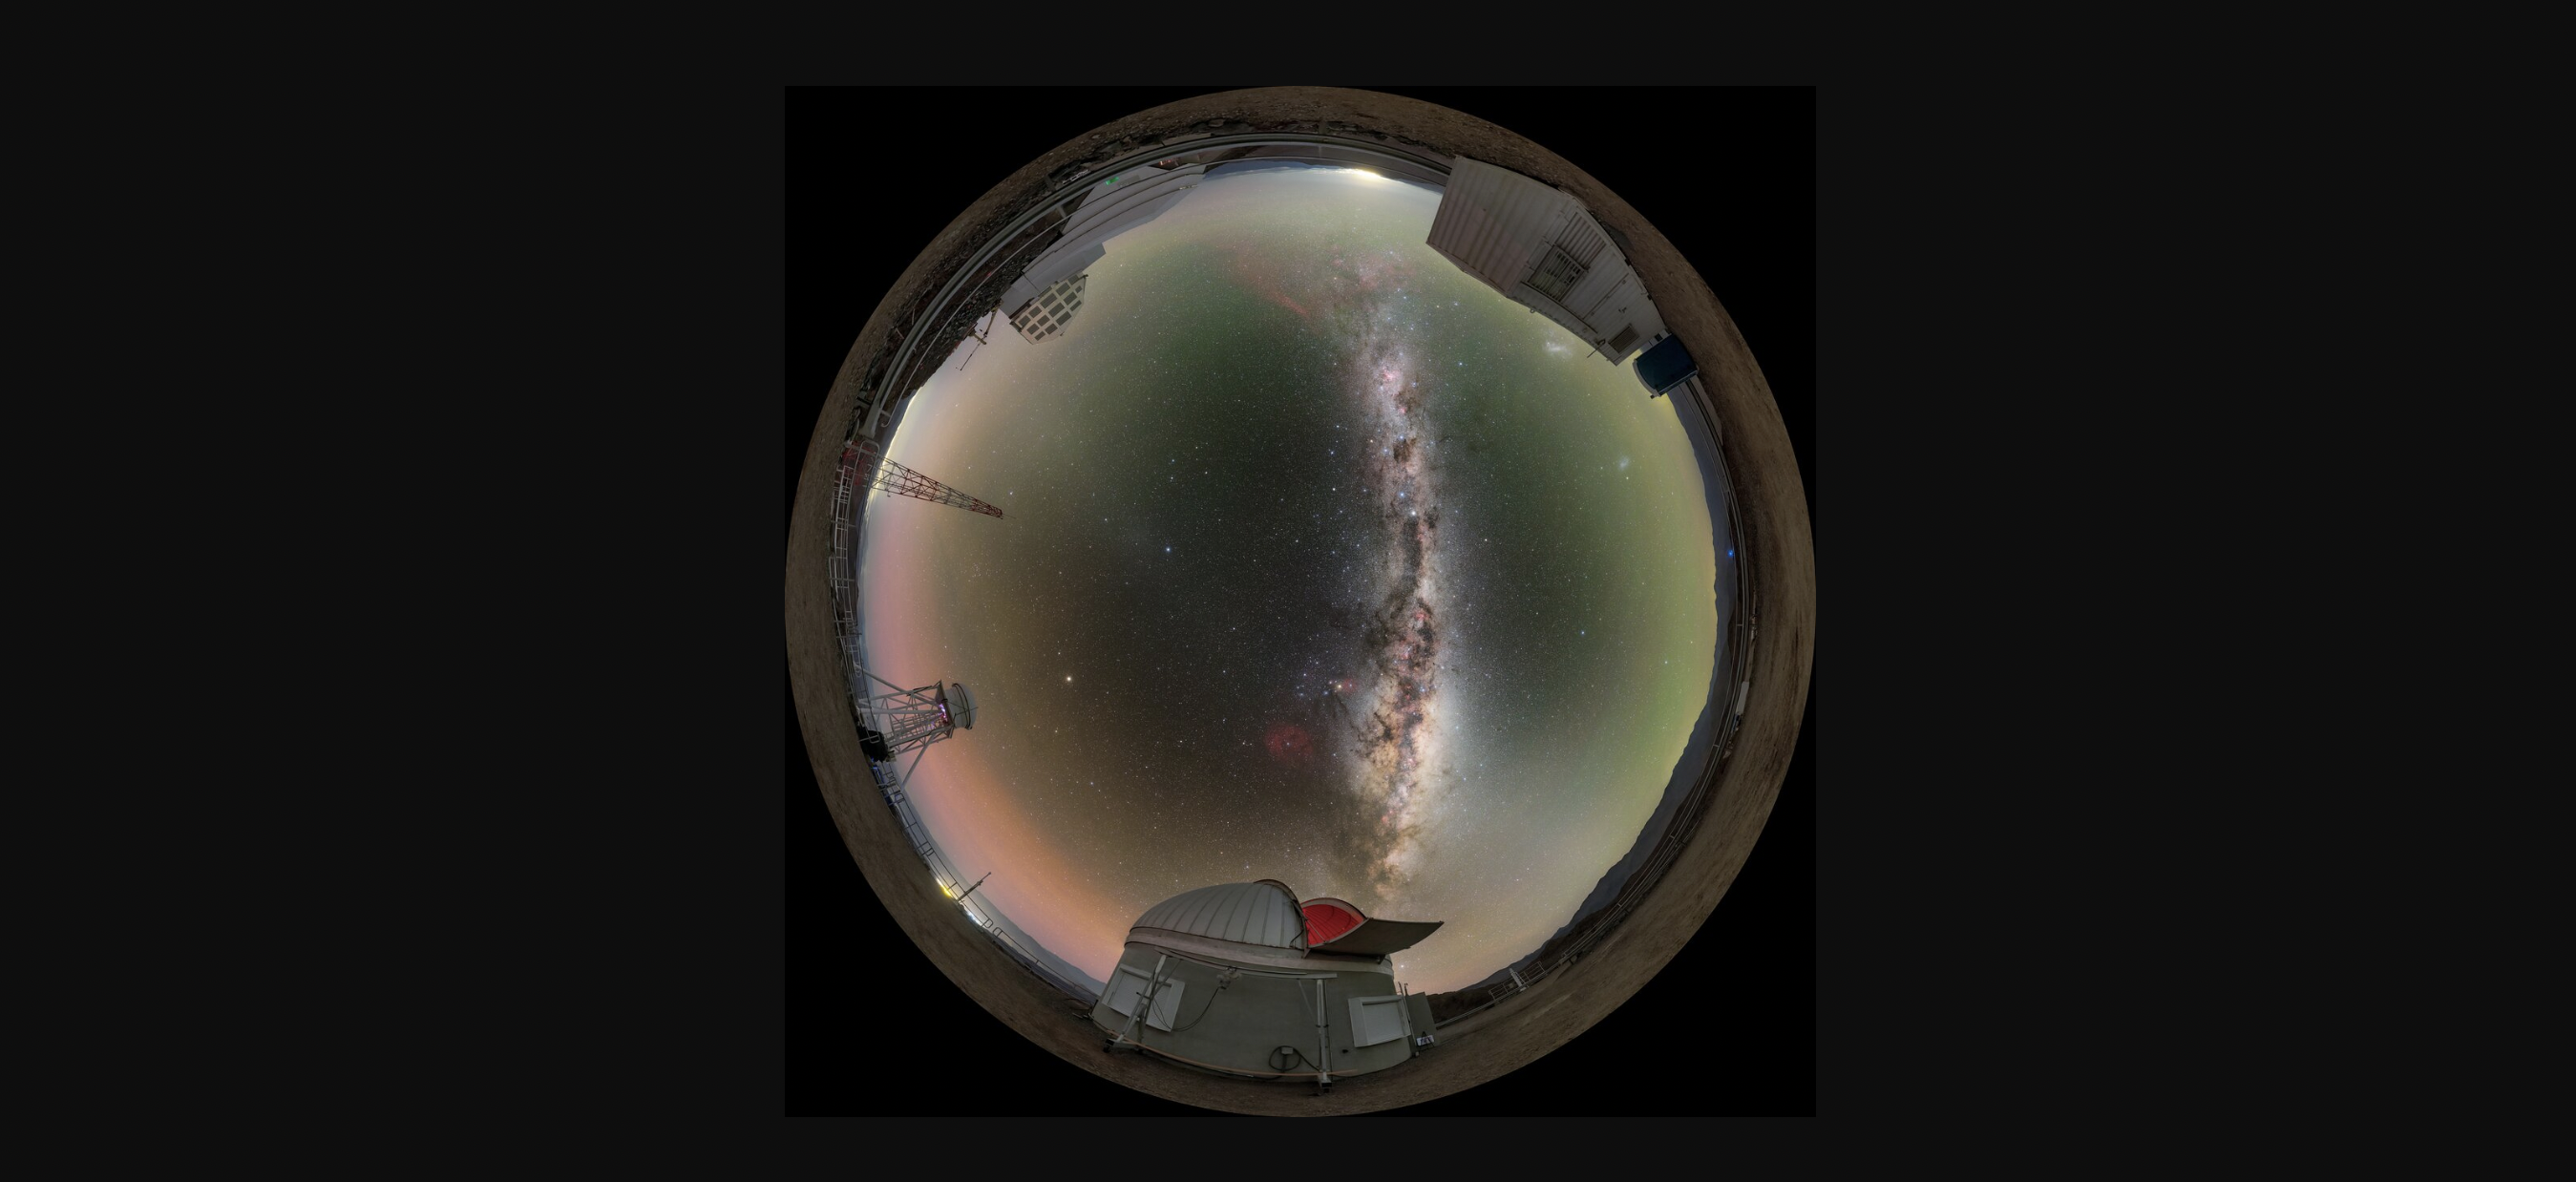

In [2]:
repo_path = "/repo/embargo"
butler = Butler(repo_path)
registry = butler.registry

for c in registry.queryCollections()[:10]:
    print(c)    

LATISS/raw/all
LATISS/calib/DM-28636/curated/19700101T000000Z
LATISS/calib/DM-28636/curated/20180101T000000Z
LATISS/calib/DM-28636/unbounded
refcats/DM-28636
refcats/DM-33444
skymaps
u/czw/DM-28920/biasGen.20210702a/20210702T215049Z
u/czw/DM-28920/darkGen.20210707d/20210707T215331Z
u/czw/DM-28920/defectGen.20210720a/20210720T230634Z


##### We can query the data by date:

In [3]:
expRecords = list(butler.registry.queryDimensionRecords('exposure'))
#expRecords = [r for r in expRecords if 'science' in r.observation_type and str(r.day_obs)[:4] == '2023' and str(r.day_obs)[4:6] == '05']
expRecords = [r for r in expRecords if 'AUXTEL_PHOTO_IMAGING' in r.science_program 
              and str(r.day_obs)[:4] == '2023' 
              and str(r.day_obs)[4:6] == '05' 
              and str(r.day_obs)[6:] == '23']

print(f"Found {len(expRecords)} records")

idlist = [r.id for r in expRecords]

Found 40 records


In [4]:
print(expRecords[0])

exposure:
  instrument: 'LATISS'
  id: 2023052300609
  physical_filter: 'SDSSr_65mm~empty'
  obs_id: 'AT_O_20230523_000609'
  exposure_time: 30.0
  dark_time: 30.2438
  observation_type: 'science'
  observation_reason: 'object'
  day_obs: 20230523
  seq_num: 609
  seq_start: 609
  seq_end: 609
  group_name: '2023-05-24T04:57:59.729'
  group_id: 2648338797290000
  target_name: 'Photo1600-1_011'
  science_program: 'AUXTEL_PHOTO_IMAGING'
  tracking_ra: 239.97671136778192
  tracking_dec: -24.019558116548627
  sky_angle: 354.9994298070654
  azimuth: 321.09078672852854
  zenith_angle: 7.7736213433177
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-05-24 05:00:09.292017', scale='tai', format='iso'), end=astropy.time.Time('2023-05-24 05:00:39.536000', scale='tai', format='iso'))


##### Now, we are going to search the raw image collection to pull some of the images from the dates we selected.

In [5]:
collections = ['LATISS/raw/all', 'LATISS/calib']
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes()[:10]:
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

48889 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
5 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
1 DatasetType('camera', {instrument}, Camera, isCalibration=True)
5 DatasetType('dark', {instrument, detector}, ExposureF, isCalibration=True)
4 DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
23 DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
0 DatasetType('gaia_dr2_20200414', {htm7}, SimpleCatalog)
0 DatasetType('skyMap', {skymap}, SkyMap)
0 DatasetType('atlas_refcat2_20220201', {htm7}, SimpleCatalog)
0 DatasetType('packages', {}, Packages)


In [6]:
datasetRefs = list(subregistry.queryDatasets(
    datasetType='raw',
    collections=collections,
    instrument='LATISS',
    detector=0,
    where = "exposure.day_obs IN (20230523) \
             AND exposure.observation_type='science' \
             AND exposure.science_program='AUXTEL_PHOTO_IMAGING' "))

print(len(datasetRefs))

40


In [8]:
ref = datasetRefs[0]

In [9]:
ref.dataId

{instrument: 'LATISS', detector: 0, exposure: 2023052300609, ...}

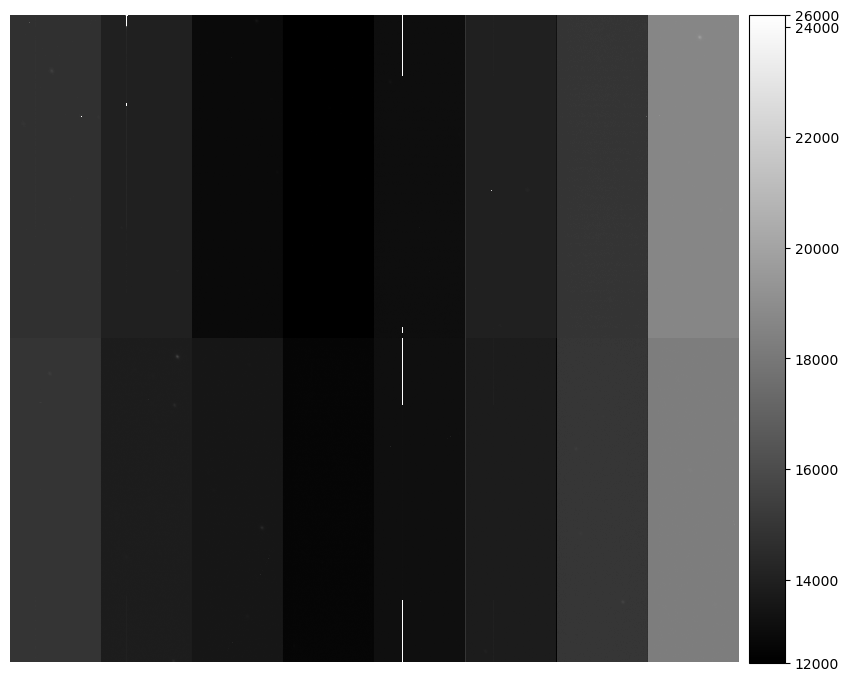

In [7]:
ref = datasetRefs[0]
raw=butler.get('raw',dataId = ref.dataId, collections=collections)

exptime = raw.getMetadata()['EXPTIME']

display(raw)

In [9]:
from lsst.ip.isr.isrTask import IsrTask

config = IsrTask.ConfigClass()
config.doDark = True
config.doBias = True
config.doFlat = False
config.doDefect = True
config.doLinearize=False
config.doBrighterFatter=False
config.doApplyGains=False
config.doOverscan=True
# The images tend to have serial structure ("banding"), 
# and this is the best option to remove it.
config.overscan.fitType: 'MEDIAN_PER_ROW' 

isrtask = IsrTask(config=config) # default configuration

# Get the calibrations
collections = "LATISS/calib"
bias = butler.get('bias',dataId = {"day_obs": 20230131, "seq_num": 151, "detector": 0},instrument='LATISS', collections=collections)
dark = butler.get('dark',dataId = {"day_obs": 20230523, "seq_num": 45, "detector": 0},instrument='LATISS', collections=collections)
defects = butler.get('defects',dataId = {"day_obs": 20230523, "seq_num": 45, "detector": 0},instrument='LATISS', collections=collections)

postISRStruct = isrtask.run( raw, 
                            camera=camera, 
                            bias=bias, 
                            dark=dark,
                            defects=defects,
                            detectorNum=0)
# Note: the task returns a struct that contains the exposure object
image = postISRStruct.exposure

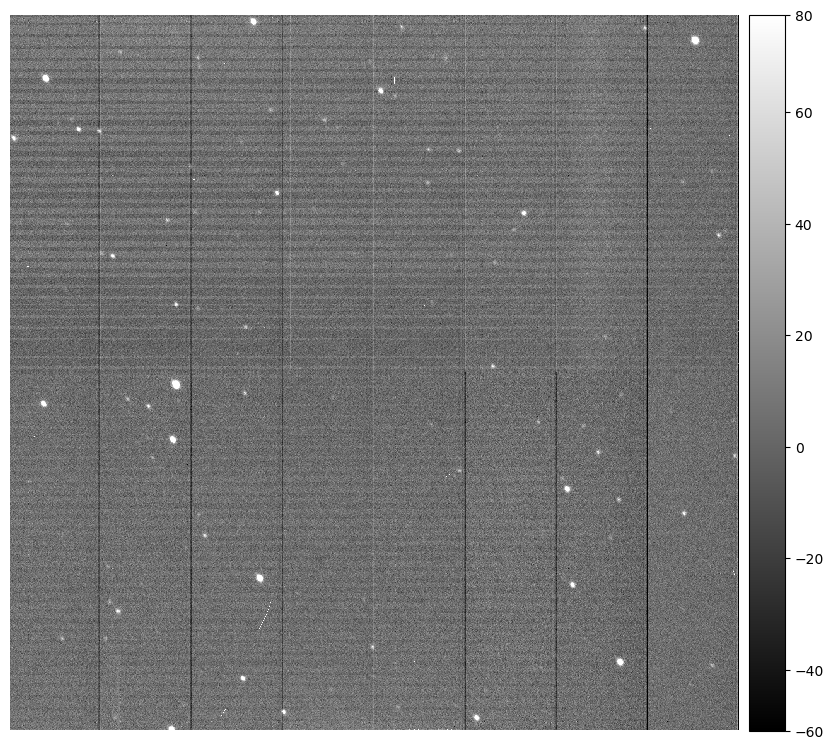

In [10]:
display(image)

In [13]:
image.writeFits("./example_auxtel_image.fits")

In [ ]:
from matplotlib.colors import SymLogNorm
plt.imshow(image.getImage().getArray(), cmap='binary' ,norm=SymLogNorm(10, vmin=-10, vmax=150000, base=10))
plt.colorbar()

In [73]:
sys.path.append('/home/a/abrought/bin')
from mixcoatl.python.mixcoatl import characterizeSpots

In [74]:
config = characterizeSpots.CharacterizeSpotsConfig()
findSpotTask = characterizeSpots.CharacterizeSpotsTask(config=config)

In [75]:
catalog = findSpotTask.run(exposure=image)

/home/a/abrought/bin/mixcoatl/python/mixcoatl/characterizeSpots.py:160: FutureWarning: Call to deprecated class ExposureIdInfo. (Deprecated in favor of lsst.meas.base.CatalogIdPacker; will be removed after v27.) -- Deprecated since version v26.
  exposureIdInfo = ExposureIdInfo()


In [76]:
catalog = catalog.sourceCat

In [77]:
len(catalog)

818

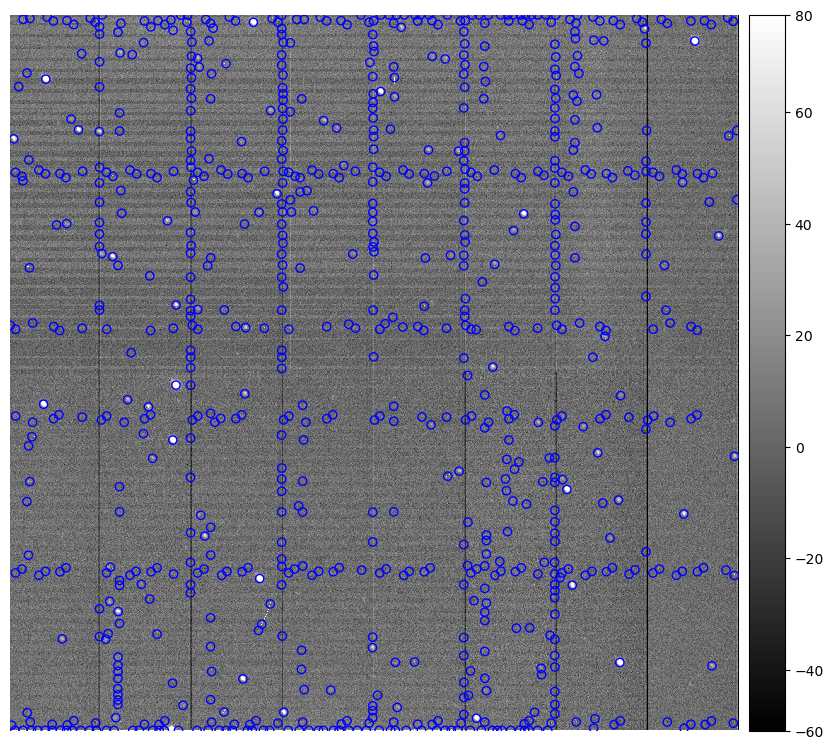

In [78]:
display(image)
plt.scatter(catalog['base_SdssCentroid_x'], catalog['base_SdssCentroid_y'], marker="o",facecolors='none', edgecolors='b')

In [79]:
catalog

<class 'lsst.afw.table.SourceCatalog'>
Non-contiguous afw.Catalog of 818 rows.
columns: id coord_ra coord_dec parent base_SdssCentroid_x base_SdssCentroid_y base_SdssCentroid_xErr base_SdssCentroid_yErr base_SdssCentroid_flag base_SdssCentroid_flag_edge base_SdssCentroid_flag_noSecondDerivative base_SdssCentroid_flag_almostNoSecondDerivative base_SdssCentroid_flag_notAtMaximum base_SdssCentroid_flag_near_edge base_SdssCentroid_flag_resetToPeak base_SdssCentroid_flag_badError base_SdssShape_xx base_SdssShape_yy base_SdssShape_xy base_SdssShape_xxErr base_SdssShape_yyErr base_SdssShape_xyErr base_SdssShape_x base_SdssShape_y base_SdssShape_instFlux base_SdssShape_instFluxErr base_SdssShape_psf_xx base_SdssShape_psf_yy base_SdssShape_psf_xy base_SdssShape_instFlux_xx_Cov base_SdssShape_instFlux_yy_Cov base_SdssShape_instFlux_xy_Cov base_SdssShape_flag base_SdssShape_flag_unweightedBad base_SdssShape_flag_unweighted base_SdssShape_flag_shift base_SdssShape_flag_maxIter base_SdssShape_flag_

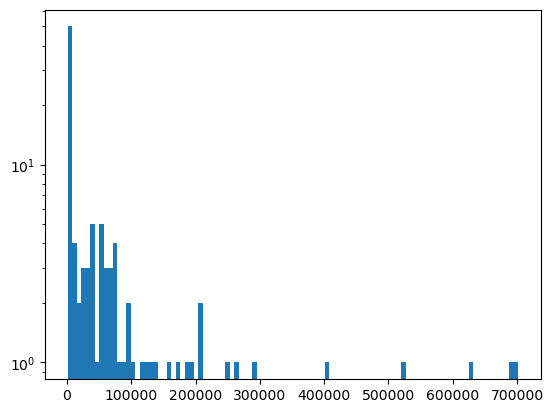

In [80]:
mask = (catalog['base_SdssShape_instFlux'] > 1e3) * (catalog['base_SdssShape_instFlux'] < 1e6) * (catalog['base_SdssCentroid_flag_near_edge'] == False)
_ = plt.hist(catalog['base_SdssShape_instFlux'][mask], bins=100)
plt.yscale('log')

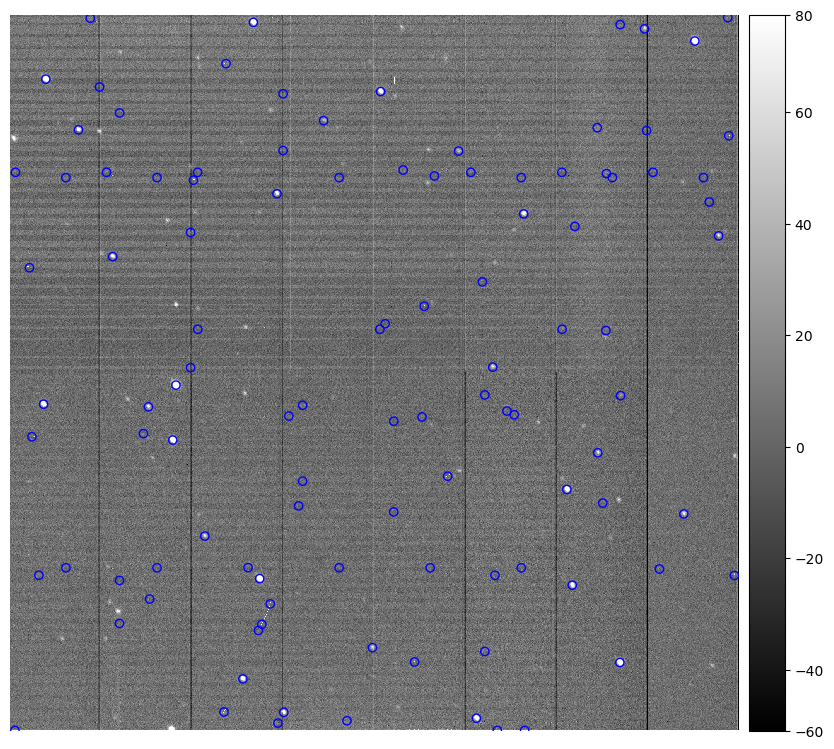

In [81]:
display(image)
plt.scatter(catalog[mask]['base_SdssCentroid_x'], catalog[mask]['base_SdssCentroid_y'], marker="o",facecolors='none', edgecolors='b')

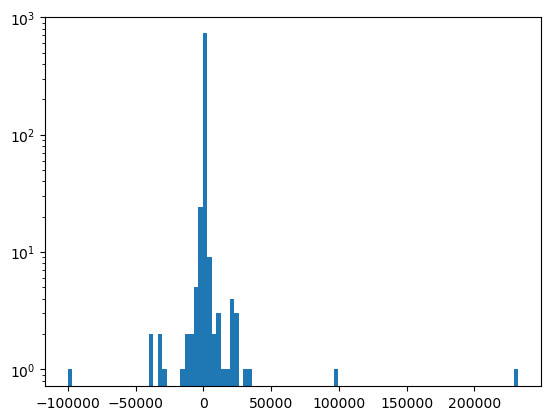

In [82]:
_ = plt.hist(catalog['base_SdssShape_xy'], bins=100)
plt.yscale('log')

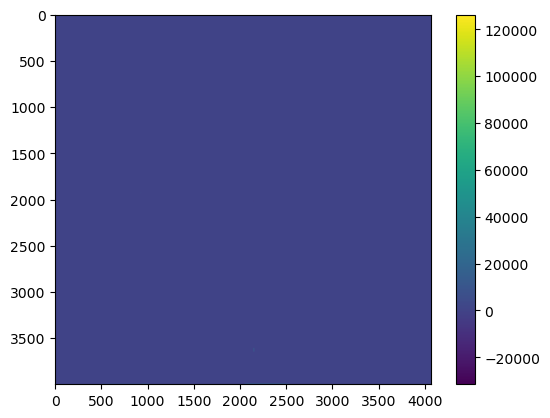

In [84]:
plt.imshow(image.getImage().array)
plt.colorbar()

In [2]:
h = fits.open("/home/a/abrought/auxtel/example_auxtel_image.fits")

In [3]:
h.info()

Filename: /home/a/abrought/auxtel/example_auxtel_image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  REB_COND      1 PrimaryHDU     461   ()      
  1  IMAGE         1 ImageHDU        34   (4072, 4000)   float32   
  2  MASK          1 ImageHDU        42   (4072, 4000)   int32   
  3  VARIANCE      1 ImageHDU        34   (4072, 4000)   float32   
  4  ARCHIVE_INDEX    1 BinTableHDU     41   10R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  5  PhotoCalib    1 BinTableHDU     36   1R x 5C   [1X, 1D, 1D, 1J, 1J]   
  6  ChebyshevBoundedField    1 BinTableHDU     41   1R x 6C   [1J, 1J, 1J, 1J, 1J, 1D]   
  7  FilterLabel    1 BinTableHDU     28   1R x 3C   [2X, 32A, 32A]   
  8  SkyWcs        1 BinTableHDU     17   1R x 1C   [1QB(8616)]   
  9  Detector      1 BinTableHDU    115   1R x 22C   [1QA(7), 1J, 1J, 1QA(13), 1J, 1J, 1J, 1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1QE(0), 1QA(3), 1J]   
 10  TransformMap    1 BinTableHDU     33   3R x 5C   [1QA(10), 1QA(

In [8]:
h_cat = fits.open("/home/a/abrought/bin/Piff/examples/572501/D00572501_z_c01_r5473p01_piff.fits")

In [9]:
h_im = fits.open("/home/a/abrought/bin/Piff/examples/572501/D00572501_z_c01_r3624p01_immasked.fits.fz")

In [10]:
h_im.info()

Filename: /home/a/abrought/bin/Piff/examples/572501/D00572501_z_c01_r3624p01_immasked.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  SCI           1 CompImageHDU    337   (2048, 4096)   float32   
  2  MSK           1 CompImageHDU     65   (2048, 4096)   int16   
  3  WGT           1 CompImageHDU     19   (2048, 4096)   float32   


In [12]:
h_cat.info()

Filename: /home/a/abrought/bin/Piff/examples/572501/D00572501_z_c01_r5473p01_piff.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      19   ()      
  1  OBJECTS       1 BinTableHDU     79   248R x 35C   [D, D, E, E, E, D, D, E, E, E, E, E, E, I, E, E, J, D, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K]   


In [15]:
h_cat[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  222 / width of table in bytes                        
NAXIS2  =                  248 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   35 / number of fields in each row                   
TTYPE1  = 'ALPHAWIN_J2000'     / label for field   1                            
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE2  = 'DELTAWIN_J2000'     / label for field   2                            
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE            
TTYPE3  = 'ERRAWIN_WORLD'   